# Project 5- Modeling (casualties)

This notebook is to create a model that will predict civilian casualties of the Yemen conflict, when knowing the
location of an air raid.  For this problem we will build a Regressive Neural Network to model the area data provided by
the Yemen Data Project.

#### Import packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from tensorflow.keras import utils
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

%matplotlib inline 
plt.style.use('fivethirtyeight')

#### Read in Data

In [2]:
df = pd.read_csv('../data/clean_df.csv')

In [3]:
df.head()

,date,incident_id,governorate,district,area,target,main_category,sub_category,min_air_raids,max_air_raids,civilian_casualties,fatalities,woman_fatalities,child_fatalities,injured,woman_injured,child_injured,confirmed_time,time_of_day
0,2015-03-26,1,Sanaa,bani al-harith,Al-Rahabah,Al-Daylami Airbase,military_security_target,military site,1,2.0,0,0,0,0,0,0,0.0,2,morning
1,2015-03-26,2,Sanaa,bani al-harith,Airport,Sana'a International Airport,infrastructure,transport,1,2.0,0,0,0,0,0,0,0.0,2,morning
2,2015-03-26,3,Sanaa,bani al-harith,Al-Sonblah Neighbourhood,Residential Area,civilian,residential area,1,2.0,29,21,3,14,8,0,7.0,2,morning
3,2015-03-26,4,Sanaa,al-sab'ein,Al-Nahdain,Presidential Palace,military_security_target,military site,1,2.0,0,0,0,0,0,0,0.0,3,morning
4,2015-03-26,5,Sanaa,al-thawrah,Al-Nahdhah,Former 1st Armoured Division,military_security_target,military site,1,2.0,0,0,0,0,0,0,0.0,3,morning


#### Resetting index to datetime index

In [4]:
df.set_index('date', inplace=True)
df.index = pd.to_datetime(df.index) 

#### Dummify columns with text

We are dummying these columns to extract the data and make the data numerically represented.

In [5]:
df = pd.get_dummies(df, columns=['main_category', 'sub_category', 'time_of_day', 
                    'confirmed_time', 'governorate', 'district', 'area', 'target'])

In [6]:
df.head()

,incident_id,min_air_raids,max_air_raids,civilian_casualties,fatalities,woman_fatalities,child_fatalities,injured,woman_injured,child_injured,...,target_three hotels,target_three vehicles,target_two military vehicles,target_unknown,target_unknown,target_vocational Institute,target_water drill,target_water truck,target_water well,target_well
date,,,,,,,,,,,,,,,,,,,,,
2015-03-26,1,1,2.0,0,0,0,0,0,0,0.0,...,0,0,0,0,0,0,0,0,0,0
2015-03-26,2,1,2.0,0,0,0,0,0,0,0.0,...,0,0,0,0,0,0,0,0,0,0
2015-03-26,3,1,2.0,29,21,3,14,8,0,7.0,...,0,0,0,0,0,0,0,0,0,0
2015-03-26,4,1,2.0,0,0,0,0,0,0,0.0,...,0,0,0,0,0,0,0,0,0,0
2015-03-26,5,1,2.0,0,0,0,0,0,0,0.0,...,0,0,0,0,0,0,0,0,0,0


## Setting up and scaling Training and Testing data 

Create X and y:  We had to remove multiple features from X as they would have leaked our target value, civilian
casualties.  This fits our scenario, as when a report comes in given the location of the raid, we want to predict
casualties without reports of casualty specifics.

In [7]:
X = df.drop(columns=['civilian_casualties', 'fatalities', 'woman_fatalities',
       'child_fatalities', 'injured', 'woman_injured', 'child_injured'])
y = df['civilian_casualties'] # Predicting casualties

Split data into training and testing datasets.

In [8]:
# Shuffle set to false on Train/Test split because it's a time series index
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=6, shuffle=False)

Apply a standard scalar to our data.  This will regualirze the result and make our model more accurtate.

In [9]:
ss = StandardScaler()
X_train_ss = ss.fit_transform(X_train)
X_test_ss = ss.transform(X_test)

### Creating a Regressive Neural Network to predict civilian casualties

Create variable input_shape to be used as a parameter in the model.

In [10]:
input_shape = X_train_ss[0].shape

This model will have 8 layers, one input and one output layer, and 6 hidden layers.

In [11]:
model = Sequential()

model.add(Dense(256, input_shape=input_shape, activation="relu")) #Input layer with 256 neurons

model.add(Dense(128, activation="relu")) # 6 Hidden Layers

model.add(Dense(128, activation='relu'))

model.add(Dense(32, activation='relu'))

model.add(Dense(32, activation='relu'))

model.add(Dense(16, activation='relu'))

model.add(Dense(8, activation='relu'))

model.add(Dense(1)) #because this is a regression prediction we only use 1 node in the last output layer

model.compile(optimizer='adam', loss='mse', metrics=['acc']) # using MSE as metric for regression

history = model.fit(X_train_ss, y_train, validation_data=(X_test_ss, y_test), epochs=50, batch_size = 512)

Epoch 1/50
33/33 [==============================] - 3s 71ms/step - loss: 163.5994 - acc: 0.3990 - val_loss: 22.9868 - val_acc: 0.6759
Epoch 2/50
33/33 [==============================] - 1s 37ms/step - loss: 190.0340 - acc: 0.4472 - val_loss: 22.4786 - val_acc: 0.8671
Epoch 3/50
33/33 [==============================] - 1s 37ms/step - loss: 60.3077 - acc: 0.8552 - val_loss: 22.8107 - val_acc: 0.8577
Epoch 4/50
33/33 [==============================] - 1s 37ms/step - loss: 64.6976 - acc: 0.7364 - val_loss: 23.5010 - val_acc: 0.8244
Epoch 5/50
33/33 [==============================] - 1s 37ms/step - loss: 51.2467 - acc: 0.8463 - val_loss: 23.4063 - val_acc: 0.9237
Epoch 6/50
33/33 [==============================] - 1s 37ms/step - loss: 32.9161 - acc: 0.7962 - val_loss: 24.0735 - val_acc: 0.9031
Epoch 7/50
33/33 [==============================] - 1s 37ms/step - loss: 56.5923 - acc: 0.8361 - val_loss: 23.4117 - val_acc: 0.7392
Epoch 8/50
33/33 [==============================] - 1s 37ms/step - 

## Plotting our Training/Testing Loss and Accuracy


#### Loss

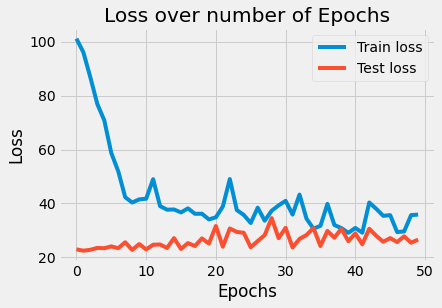

In [12]:
plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='Test loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss over number of Epochs')
plt.legend();
plt.savefig('../images/neural_network_loss.png');

Our loss values for training and testing leveled off at 5.0957 and 27.1714 respectively after 50 epochs, although this
value tended to jump back and forth throughout all the epochs.  While there is little gain from 30 epochs to 50, there
is a trend downward showing the loss improving as the model reaches 50 epochs.



#### Accuracy

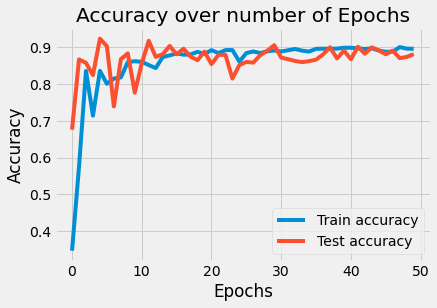

In [13]:
plt.plot(history.history['acc'], label='Train accuracy')
plt.plot(history.history['val_acc'], label='Test accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy over number of Epochs')
plt.legend();
plt.savefig('../images/neural_network_accuracy.png');

Our accuracy score ended at .8988 for training and .8945 for testing, so our model was not overfit to the training data,
 however the value jumped back and forth around .87-.88.  This model may improve slightly with more epoch but the model's
 accuracy will not be that much different as both the training and testing data have reached a theoretical asymptote of .9.

## Overall

We created a regressive nueral network to predict civilian casualties when given the location of an air raid.  Our model is 89.45% accurate in estimating civilian casuatlies when provided data on where an air raid took place. This
model will help recommend how much aid to allocate towards medical resources, funding, and personnel based on location of
 the attack.  This model would also be usefull by the militaries waging this conflict as it will help gauge the risk of
 civilian casualties when plaing an attack.